In [16]:
import requests
import random
from bs4 import BeautifulSoup
from os import listdir
from os.path import isfile, join
import pandas as pd
import ast
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import plotly.express as px
import numpy as np
import scipy

In [2]:
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [3]:
pd.set_option('display.max_columns', 1000)

In [4]:
month_folders = ['April2023', 'August2023', 'February2023', 'January2022',
                 'January2023', 'July2023', 'June2023', 'March2023', 'May2023', 'September2023'];

In [5]:
raw_df = pd.DataFrame();

current_paths = [];
for month in month_folders:
    current_paths = current_paths + [join(month, x) for x in listdir(month) if '.csv' in x]

for current_path in current_paths:
    df_temp = pd.read_csv(current_path);
    raw_df = pd.concat([raw_df, df_temp])

raw_df = raw_df.reset_index(drop = True)

In [6]:
df_selected = raw_df[['backers_count', 'blurb', 
                      'country', 'creator',
                      'currency', 'currency_trailing_code',
                      'disable_communication', 'fx_rate',
                      'goal', 'is_starrable', 'name',
                      'pledged', 'slug', 'spotlight',
                      'staff_pick', 'state', 'usd_exchange_rate',
                      'usd_pledged']]

In [7]:
corpus = [];
corpus_index = []

for index, row in df_selected.iterrows():
    try:
        sentence = [row['name'] + '. ' + row['slug'] + '. ' + row['blurb']];
        corpus = corpus + sentence;
        corpus_index.append(index);
    
    except:
        continue;

In [58]:
df_corpus = pd.DataFrame({'sentences' : corpus}, index = corpus_index)

In [9]:
corpus_preprocessed = [simple_preprocess(i) for i in corpus]

In [10]:
model = Word2Vec(corpus_preprocessed, min_count = 1, vector_size = 7)

In [11]:
vocabulary = []
for index, word in enumerate(model.wv.index_to_key):
    vocabulary = vocabulary + [{'t' : list(model.wv[word])[0],
                                'u' : list(model.wv[word])[1],
                                'v' : list(model.wv[word])[2], 
                                'w' : list(model.wv[word])[3], 
                                'x' : list(model.wv[word])[4],
                                'y' : list(model.wv[word])[5],
                                'z' : list(model.wv[word])[6],
                                'word' : word}]

In [22]:
df_high_dimension_vocab = pd.DataFrame(vocabulary).set_index('word', drop = True)

In [13]:
wv_reduced = PCA(n_components = 2)
wv_reduced.fit(df_high_dimension_vocab[['t', 'u', 'v', 'w', 'x', 'y', 'z']])
reduced_vocab_vectors = wv_reduced.transform(df_high_dimension_vocab[['t', 'u', 'v', 'w', 'x', 'y', 'z']])

In [17]:
df_reduced_vocab = pd.DataFrame({'x': list(reduced_vocab_vectors[:, 0]), 
                                 'y': list(reduced_vocab_vectors[:, 1]),
                                 'word' : df_high_dimension_vocab['word']})

<Axes: xlabel='x', ylabel='y'>

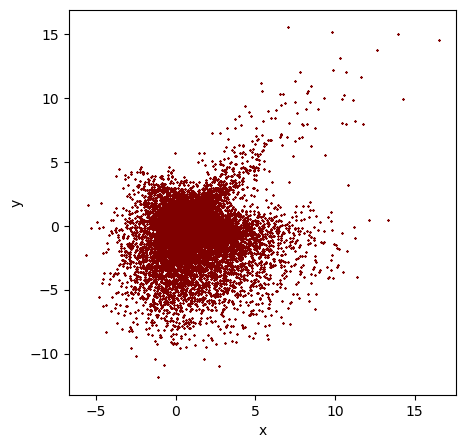

In [18]:
df_reduced_vocab.plot.scatter(x = 'x', y = 'y', s = 1, marker = 'x', figsize = (5, 5), color = [[0.5, 0.0, 0.0]])

In [60]:
df_w_sentences = pd.concat([df_selected[['backers_count',
                                     'fx_rate',
                                     'goal',
                                     'pledged',
                                     'state']].loc[df_corpus.index],
                        df_corpus], axis = 1)

In [61]:
df_w_sentences[['t', 'u', 'v', 'w', 'x', 'y', 'z']] = np.nan

In [63]:
df_w_sentences

,backers_count,fx_rate,goal,pledged,state,sentences,t,u,v,w,x,y,z
0,230,1.238278,1999.0,6746.00,successful,Cisco CCNA and CCNA Security for the Real Worl...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,34,1.238278,200.0,1079.00,successful,Strong File Encryption Tool. strong-file-encry...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,226,1.000000,10000.0,17451.00,successful,YaCyPi - Turnkey Raspberry Pi based Internet S...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,655,1.000000,50000.0,51309.83,successful,"Everydisk – Easily access all your computers, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,24,0.618861,200.0,487.00,successful,Traccar Client for iOS. traccar-client-for-ios...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
361861,3,1.249716,12000.0,65.00,failed,Treaty Pie Dessert Extraordinaire. treaty-pie-...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
361862,26,1.249716,3000.0,4882.00,successful,Flights of Fancy - A trio of brand new print e...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
361863,99,1.074469,5000.0,28074.50,successful,Transform Your Workspace with ERGOZ™. ergoztm-...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
361864,10,0.738828,1500.0,1500.00,successful,"GamerFix.ca. gamerfixca. Video gaming, Movies ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
def sentence_median(sentence_string):
    processed_sentence = simple_preprocess(sentence_string);
    sentence_list = [];
    sentence_median = 7*[np.nan];
    for word in processed_sentence:
        try:      
            sentence_list.append(df_high_dimension_vocab.loc[word])
        except:
            break;
            
    sentence_array = np.array(sentence_list)
    return np.median(sentence_array, axis = 0)

In [ ]:
error_index = []
for index, row in df_w_sentences.iterrows():
    try:
        df_w_sentences.loc[index, ['t', 'u', 'v', 'w', 'x', 'y', 'z']] = sentence_median(row['sentences'])
    except:
        error_index.append(index)

In [92]:
df_w_sentences

,backers_count,fx_rate,goal,pledged,state,sentences,t,u,v,w,x,y,z
0,230,1.238278,1999.0,6746.00,successful,Cisco CCNA and CCNA Security for the Real Worl...,-3.027842,-2.188033,1.159999,1.918514,0.399868,-1.565474,1.382393
1,34,1.238278,200.0,1079.00,successful,Strong File Encryption Tool. strong-file-encry...,0.230554,-2.119461,-0.407646,2.752960,0.214896,0.662422,1.973701
2,226,1.000000,10000.0,17451.00,successful,YaCyPi - Turnkey Raspberry Pi based Internet S...,-1.172962,-2.981460,-0.562862,2.517519,0.315752,-1.033590,2.172634
3,655,1.000000,50000.0,51309.83,successful,"Everydisk – Easily access all your computers, ...",-3.020664,-3.421177,1.209325,3.813275,0.943118,-0.765127,1.347683
4,24,0.618861,200.0,487.00,successful,Traccar Client for iOS. traccar-client-for-ios...,-0.217545,-3.884567,-1.775199,3.456568,2.533460,-0.172614,1.890694
...,...,...,...,...,...,...,...,...,...,...,...,...,...
361861,3,1.249716,12000.0,65.00,failed,Treaty Pie Dessert Extraordinaire. treaty-pie-...,-2.987972,-0.081058,2.585926,1.330560,0.773816,-2.064120,0.943447
361862,26,1.249716,3000.0,4882.00,successful,Flights of Fancy - A trio of brand new print e...,-0.087660,-1.167448,3.360322,1.712534,-1.746631,-3.416441,1.047190
361863,99,1.074469,5000.0,28074.50,successful,Transform Your Workspace with ERGOZ™. ergoztm-...,-2.264019,-1.960554,1.202153,4.105859,0.617760,-0.002033,0.313317
361864,10,0.738828,1500.0,1500.00,successful,"GamerFix.ca. gamerfixca. Video gaming, Movies ...",-2.559416,-1.195013,1.562588,1.935960,0.297486,-1.750213,1.632974


In [93]:
df_w_sentences['goal_usd'] = df_w_sentences['goal'] * df_w_sentences['fx_rate']

In [94]:
df_w_sentences['pledged_usd'] = df_w_sentences['pledged'] * df_w_sentences['fx_rate']

In [95]:
df_cluster = df_w_sentences[['state','backers_count', 'goal_usd', 'pledged_usd','t', 'u', 'v', 'w', 'x', 'y', 'z']]

In [99]:
set(df_cluster['state'])

{'canceled',
 'failed',
 'live',
 'started',
 'submitted',
 'successful',
 'suspended'}

In [104]:
def map_state_to_number(state_string):
    lookup = {"failed": -3.0,
              "canceled": -2.0,
              "suspended" : -1.0,
              "submitted" : 0.0,
              "started" : 1.0,
              "live" : 2.0,
              "successful" : 3.0};
    try:
        value = lookup[state_string];
    except:
        value = np.nan;
        
    return value;

In [101]:
df_cluster_copy = df_cluster.copy()

In [102]:
df_cluster_copy.columns

Index(['state', 'backers_count', 'goal_usd', 'pledged_usd', 't', 'u', 'v', 'w',
       'x', 'y', 'z'],
      dtype='object')

In [ ]:
df_cluster_copy['state'] = df_cluster['state'].apply(lambda x : map_state_to_number(x))

array([[<Axes: title={'center': 'state'}>]], dtype=object)

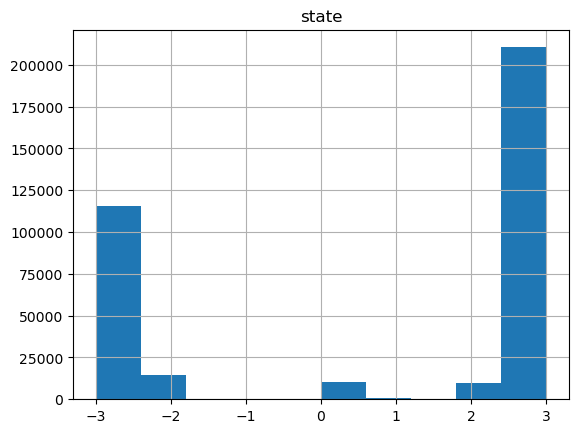

In [110]:
df_cluster_copy.hist(column = 'state', grid = True)

In [113]:
df_cluster_copy.to_csv("./kickstarter_numerical_clustering_dataset.csv", index = False)